<a href="https://colab.research.google.com/github/DenizzEmre/loan-default-predictor/blob/main/Loan_Default_Prediction_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Definition¶

The goal of this project is to analyze and address the challenges associated with loan defaults in the context of our lending institution. By leveraging data analysis and predictive modeling techniques, the project aims to optimize the loan approval process and reduce the risk of defaults.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,f1_score,precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
#from lightgbm import LGBMClassifier
#from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler,SMOTE
from collections import Counter
import warnings
warnings.filterwarnings("ignore")


from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler


## Data Insights

In [2]:
df = pd.read_csv('Loan_Default.csv')
df.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

In [4]:
df.describe()

,ID,year,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,LTV,Status,dtir1
count,148670.000000,148670.0,1.486700e+05,112231.000000,112031.000000,109028.000000,148629.000000,1.335720e+05,139520.000000,148670.000000,133572.000000,148670.000000,124549.000000
mean,99224.500000,2019.0,3.311177e+05,4.045476,0.441656,3224.996127,335.136582,4.978935e+05,6957.338876,699.789103,72.746457,0.246445,37.732932
std,42917.476598,0.0,1.839093e+05,0.561391,0.513043,3251.121510,58.409084,3.599353e+05,6496.586382,115.875857,39.967603,0.430942,10.545435
min,24890.000000,2019.0,1.650000e+04,0.000000,-3.638000,0.000000,96.000000,8.000000e+03,0.000000,500.000000,0.967478,0.000000,5.000000
25%,62057.250000,2019.0,1.965000e+05,3.625000,0.076000,581.490000,360.000000,2.680000e+05,3720.000000,599.000000,60.474860,0.000000,31.000000
50%,99224.500000,2019.0,2.965000e+05,3.990000,0.390400,2596.450000,360.000000,4.180000e+05,5760.000000,699.000000,75.135870,0.000000,39.000000
75%,136391.750000,2019.0,4.365000e+05,4.375000,0.775400,4812.500000,360.000000,6.280000e+05,8520.000000,800.000000,86.184211,0.000000,45.000000
max,173559.000000,2019.0,3.576500e+06,8.000000,3.357000,60000.000000,360.000000,1.650800e+07,578580.000000,900.000000,7831.250000,1.000000,61.000000


In [5]:
df.columns = [col.lower() for col in df.columns]  #to standartize it

In [6]:
df.duplicated().value_counts()

False    148670
dtype: int64

There is no duplicates in data

Now check the nulls:

In [7]:
df.isnull().sum()

id                               0
year                             0
loan_limit                    3344
gender                           0
approv_in_adv                  908
loan_type                        0
loan_purpose                   134
credit_worthiness                0
open_credit                      0
business_or_commercial           0
loan_amount                      0
rate_of_interest             36439
interest_rate_spread         36639
upfront_charges              39642
term                            41
neg_ammortization              121
interest_only                    0
lump_sum_payment                 0
property_value               15098
construction_type                0
occupancy_type                   0
secured_by                       0
total_units                      0
income                        9150
credit_type                      0
credit_score                     0
co-applicant_credit_type         0
age                            200
submission_of_applic

- We will deeply analyze null values in the section 'Preprocessing' and fill them with specific strategies. Now, we explore the data.

In [8]:
# Convert "Status" column to categorical
df['status'] = df['status'].astype('category')

# Define the mapping for replacement
status_mapping = {0: 'Not Approved', 1: 'Approved'}

# Replace the numeric values with labels
df['status'] = df['status'].replace(status_mapping)


## Data Insights- Visualizations

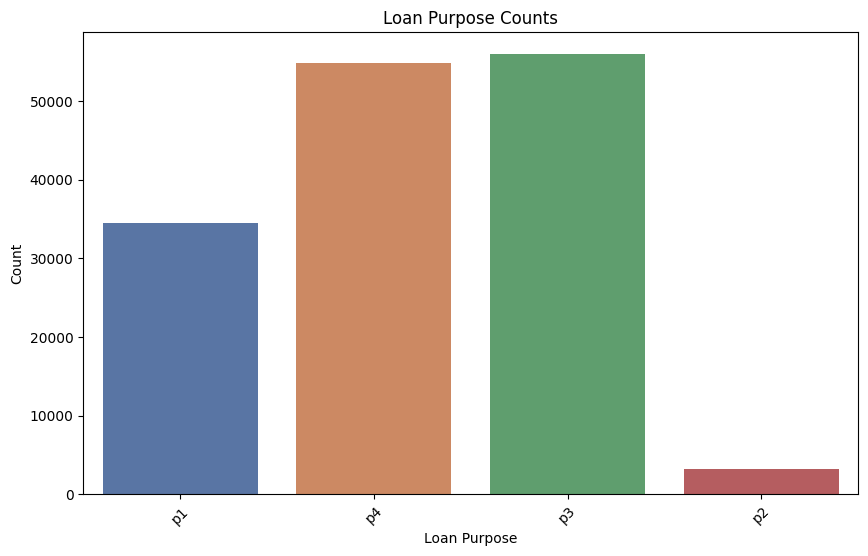

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='loan_purpose', palette='deep')
plt.title('Loan Purpose Counts')
plt.xlabel('Loan Purpose')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Show the plot
plt.show()

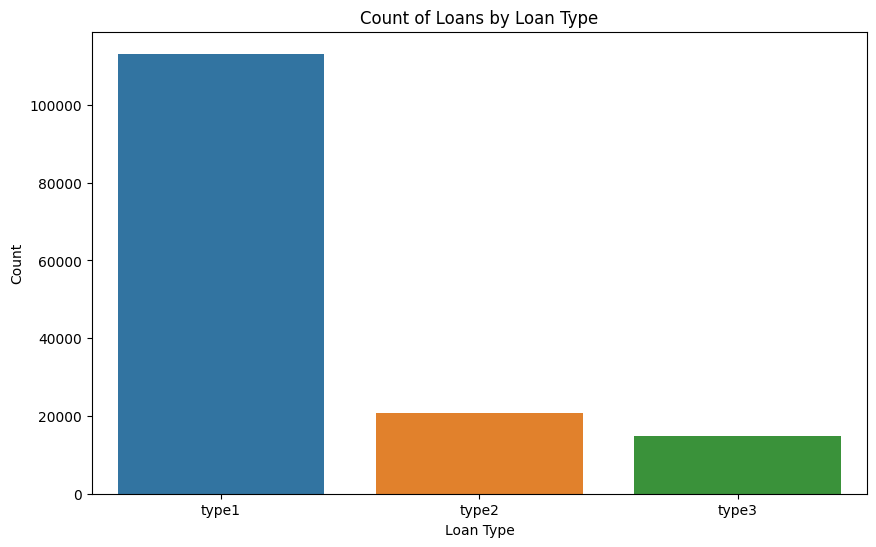

In [10]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='loan_type')
plt.xlabel('Loan Type')
plt.ylabel('Count')
plt.title('Count of Loans by Loan Type')
plt.show()


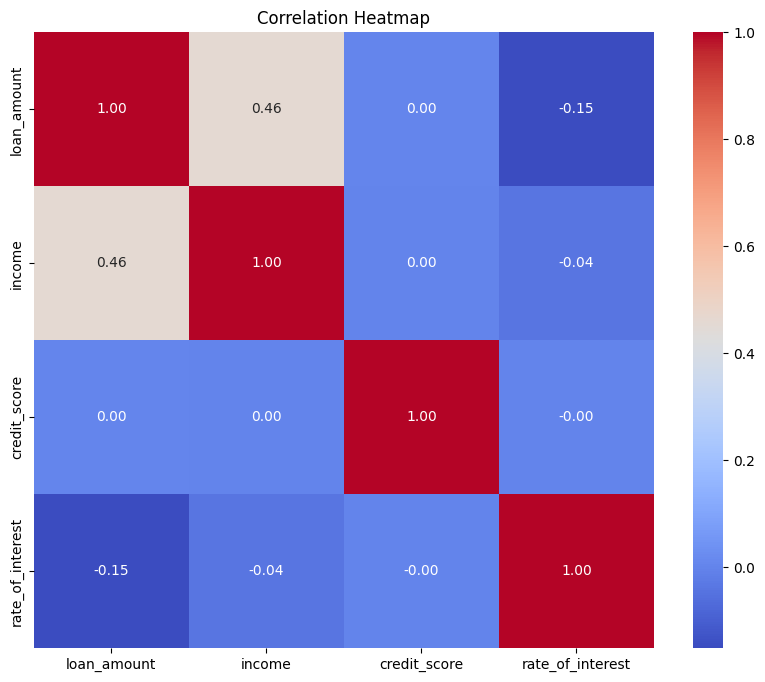

In [11]:
plt.figure(figsize=(10, 8))
correlation_matrix = df[['loan_amount', 'income', 'credit_score', 'rate_of_interest']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

These variables were chosen based on their importance in the context of loans and financial analysis. The goal is to gain insights into relationships and patterns within the data that are relevant to  analysis goals.

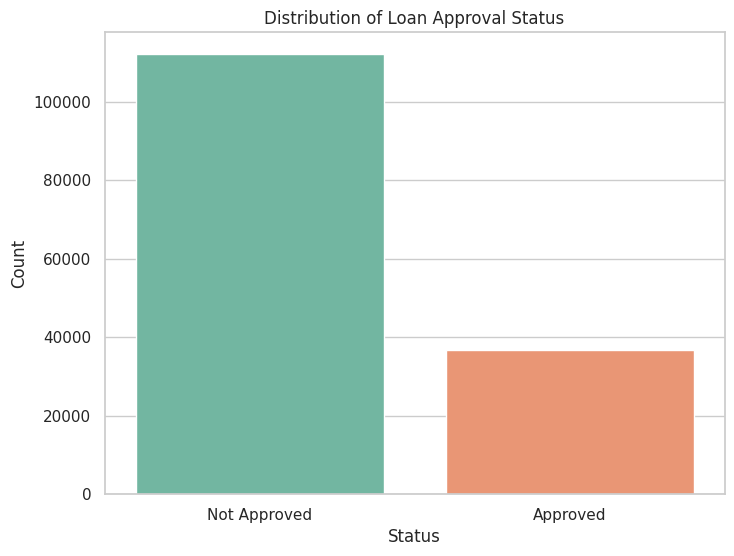

In [12]:
# Set the style of the plot
sns.set(style="whitegrid")

# Create a bar plot for the "Status" column
plt.figure(figsize=(8, 6))
sns.countplot(x="status", data=df, palette="Set2")

# Add labels and a title
plt.xlabel("Status")
plt.ylabel("Count")
plt.title("Distribution of Loan Approval Status")

# Show the plot
plt.show()


In [13]:
df["status"].value_counts(normalize=True)

Not Approved    0.753555
Approved        0.246445
Name: status, dtype: float64

**Observation:** There is an imbalance between classes. Therefore, I will address this imbalance in the preprocessing and modeling steps to ensure robust model performance.







##  Data Cleaning

**Gender Column:** Due to ethical considerations and potential legal restrictions (like those from the Equal Credit Opportunity Act in the U.S.), using gender as a predictor in loan default models is generally discouraged and could be considered discriminatory. Then drop the gender column.

In [14]:
# Drop the gender column
df = df.drop(columns='gender')

**Year Column:**  Let's analyze the effects of years.

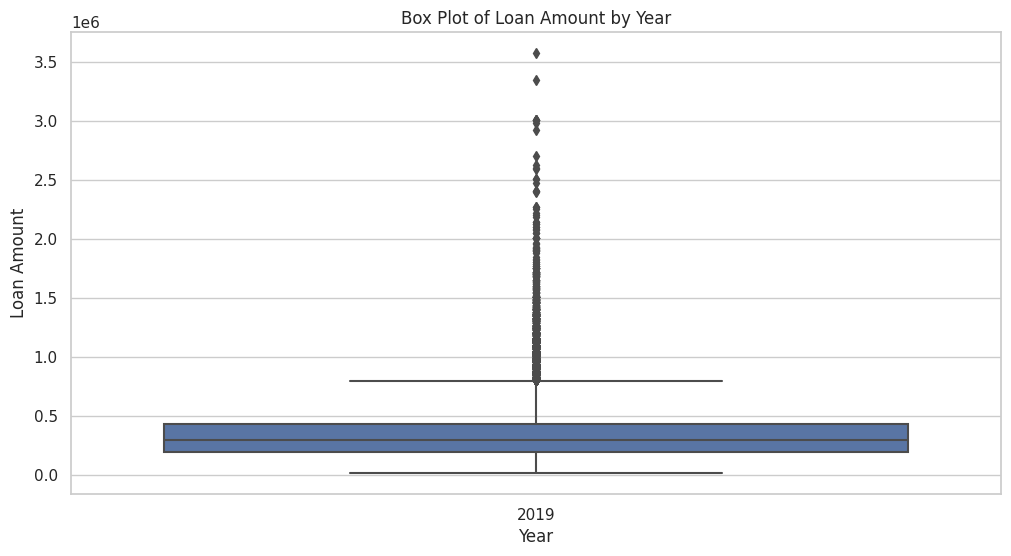

In [15]:
# Create a box plot for 'loan_amount' by year
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
sns.boxplot(x='year', y='loan_amount', data=df)
plt.xlabel('Year')  # Set x-axis label
plt.ylabel('Loan Amount')  # Set y-axis label
plt.title('Box Plot of Loan Amount by Year')  # Set plot title

plt.show()



Above boxplot shows that the data mainly has the info from 2019. Lets double-check whether there is an outlier.

In [16]:
 #Filter rows where 'year' is different from 2019
different_years = df[df['year'] != 2019]

# Count the number of rows
count_different_years = len(different_years)

# Print the count and the IDs
print(f"Number of rows with year different from 2019: {count_different_years}")


Number of rows with year different from 2019: 0


So, there is only one spesific year, 2019,  therefore we cannot use year in time-analysis. Drop it.


In [17]:
df = df.drop(columns='year')

Here are more observations regarding construction_type and secured_by columns:

In [18]:
construction_type_counts = df['construction_type'].value_counts()
secured_by_counts=df['secured_by'].value_counts()
# Print the counts
print(construction_type_counts)
print(secured_by_counts)


sb    148637
mh        33
Name: construction_type, dtype: int64
home    148637
land        33
Name: secured_by, dtype: int64


**Interpretation:** Dropping these columns helps address class imbalance issues and ensures that the model focuses on more informative and balanced features, leading to improved model performance and interpretability.

In [19]:
df.drop(['id','secured_by', 'construction_type'], axis=1, inplace=True)


In [20]:
total_units_counts = df['total_units'].value_counts()

print(total_units_counts)


1U    146480
2U      1477
3U       393
4U       320
Name: total_units, dtype: int64


 - I will address class imbalance during preprocessing to retain the 'total_units' column and enhance model performance.

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 29 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   loan_limit                 145326 non-null  object  
 1   approv_in_adv              147762 non-null  object  
 2   loan_type                  148670 non-null  object  
 3   loan_purpose               148536 non-null  object  
 4   credit_worthiness          148670 non-null  object  
 5   open_credit                148670 non-null  object  
 6   business_or_commercial     148670 non-null  object  
 7   loan_amount                148670 non-null  int64   
 8   rate_of_interest           112231 non-null  float64 
 9   interest_rate_spread       112031 non-null  float64 
 10  upfront_charges            109028 non-null  float64 
 11  term                       148629 non-null  float64 
 12  neg_ammortization          148549 non-null  object  
 13  interest_only 

## Quick Summary until now

- Gender, ID, year, construction_type, secured_by are dropped.
- There are missing values and I will fill these values in a Pipeline in the modelling stage.  

## Preprocessing

## Age is object!

Credit Behavior by Age Group: Different age groups might exhibit distinct credit behaviors. For example, younger borrowers might have a different default risk compared to older ones due to factors like job stability, income levels, and financial obligations.

In [22]:
# Convert age ranges to ordinal values
# Convert all entries in 'age' to strings and handle NaN values
df['age'] = df['age'].astype(str)

df['age'] = df['age'].replace('nan', 'unknown')

# Now we can sort the unique age range strings and create the ordinal mapping
age_ranges = sorted(df['age'].unique())
ordinal_age_mapping = {age_range: index for index, age_range in enumerate(age_ranges)}
df['age_ordinal'] = df['age'].map(ordinal_age_mapping)


**Remark: ** Note that the alternative approach to above code is creating a pipeline as below:
***
#Define the encoding for the ordinal 'age' column

ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories=[age_ranges]))  
])
***

In [23]:
# Drop the original age column
df = df.drop(columns=['age'])

In [24]:
# Identify categorical and numerical columns
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
numerical_columns = df.select_dtypes(exclude=['object']).columns.tolist()

# Confirm the lists of categorical and numerical columns
print("Categorical Columns:")
print(categorical_columns)
print("\nNumerical Columns:")
print(numerical_columns)


Categorical Columns:
['loan_limit', 'approv_in_adv', 'loan_type', 'loan_purpose', 'credit_worthiness', 'open_credit', 'business_or_commercial', 'neg_ammortization', 'interest_only', 'lump_sum_payment', 'occupancy_type', 'total_units', 'credit_type', 'co-applicant_credit_type', 'submission_of_application', 'region', 'security_type']

Numerical Columns:
['loan_amount', 'rate_of_interest', 'interest_rate_spread', 'upfront_charges', 'term', 'property_value', 'income', 'credit_score', 'ltv', 'status', 'dtir1', 'age_ordinal']


## Back to the missing values! Handling strategy.  

In [25]:
(df.isnull().sum()/len(df))*100

loan_limit                    2.249277
approv_in_adv                 0.610749
loan_type                     0.000000
loan_purpose                  0.090133
credit_worthiness             0.000000
open_credit                   0.000000
business_or_commercial        0.000000
loan_amount                   0.000000
rate_of_interest             24.509989
interest_rate_spread         24.644515
upfront_charges              26.664425
term                          0.027578
neg_ammortization             0.081388
interest_only                 0.000000
lump_sum_payment              0.000000
property_value               10.155378
occupancy_type                0.000000
total_units                   0.000000
income                        6.154571
credit_type                   0.000000
credit_score                  0.000000
co-applicant_credit_type      0.000000
submission_of_application     0.134526
ltv                          10.155378
region                        0.000000
security_type            

+ Given the missing data information, I want to have a dual approach of column-specific imputation coupled with pipeline integration. For columns with substantial missing values, such as rate_of_interest, Interest_rate_spread, Upfront_charges, property_value, LTV, and dtir1, an in-depth analysis to determine the appropriate imputation method is better.

+ Then, I plan to systematize the chosen imputation methods within a ColumnTransformer, ensuring a consistent and automated application of these methods to both the training and testing sets.


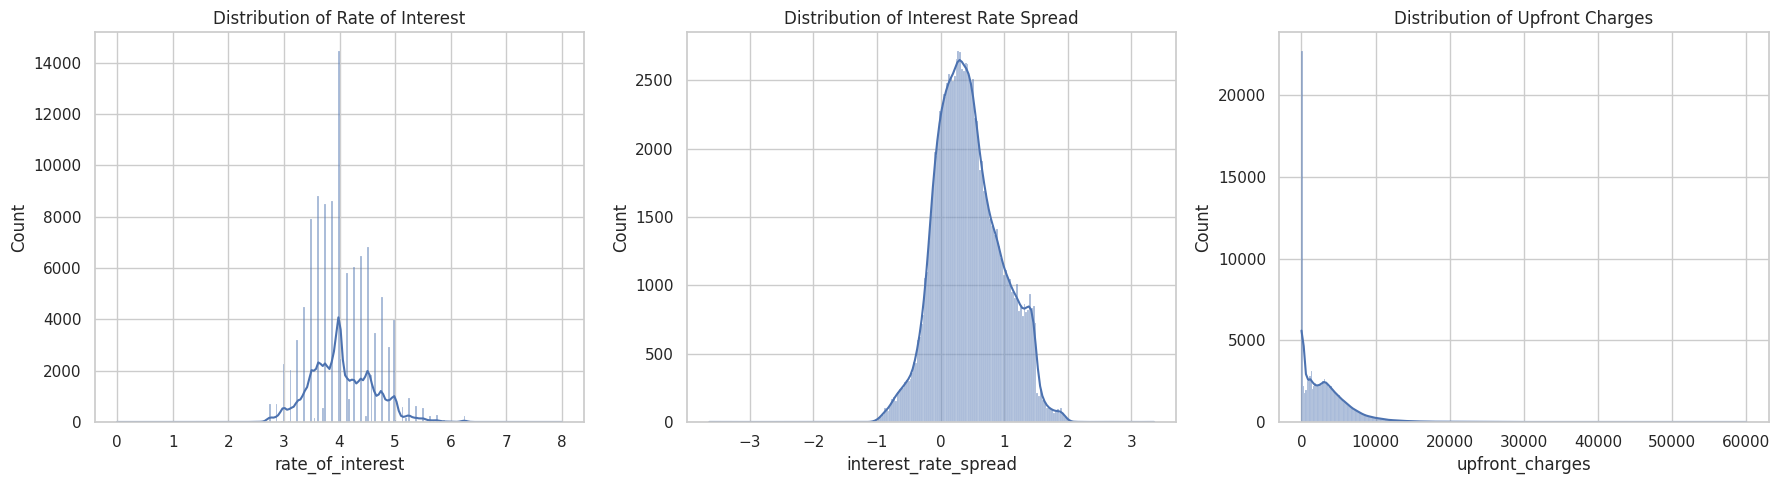

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the matplotlib figure with a specified figure size
plt.figure(figsize=(18, 5))

# Histogram for 'rate_of_interest'
plt.subplot(1, 3, 1)  # (rows, columns, panel number)
sns.histplot(df['rate_of_interest'].dropna(), kde=True)
plt.title('Distribution of Rate of Interest')

# Histogram for 'interest_rate_spread'
plt.subplot(1, 3, 2)
sns.histplot(df['interest_rate_spread'].dropna(), kde=True)
plt.title('Distribution of Interest Rate Spread')

# Histogram for 'upfront_charges'
plt.subplot(1, 3, 3)
sns.histplot(df['upfront_charges'].dropna(), kde=True)
plt.title('Distribution of Upfront Charges')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


Explanation of above histograms:
+ The "Rate of Interest" and "Interest Rate Spread" features, exhibiting normal distributions, are well-suited for mean imputation when addressing missing values. The mean is a reliable indicator of central tendency for symmetric distributions, offering a balanced central point that reflects the typical values of these features.

+ Conversely, "Upfront Charges" display a right-skewed distribution, suggesting that a significant number of very high values are pulling the mean to the right. Therefore, the median, which is not swayed by such outliers, is a better choice for imputation. Using the median ensures that the imputed values align more closely with the most common range of the data, preserving its original distributional characteristics.

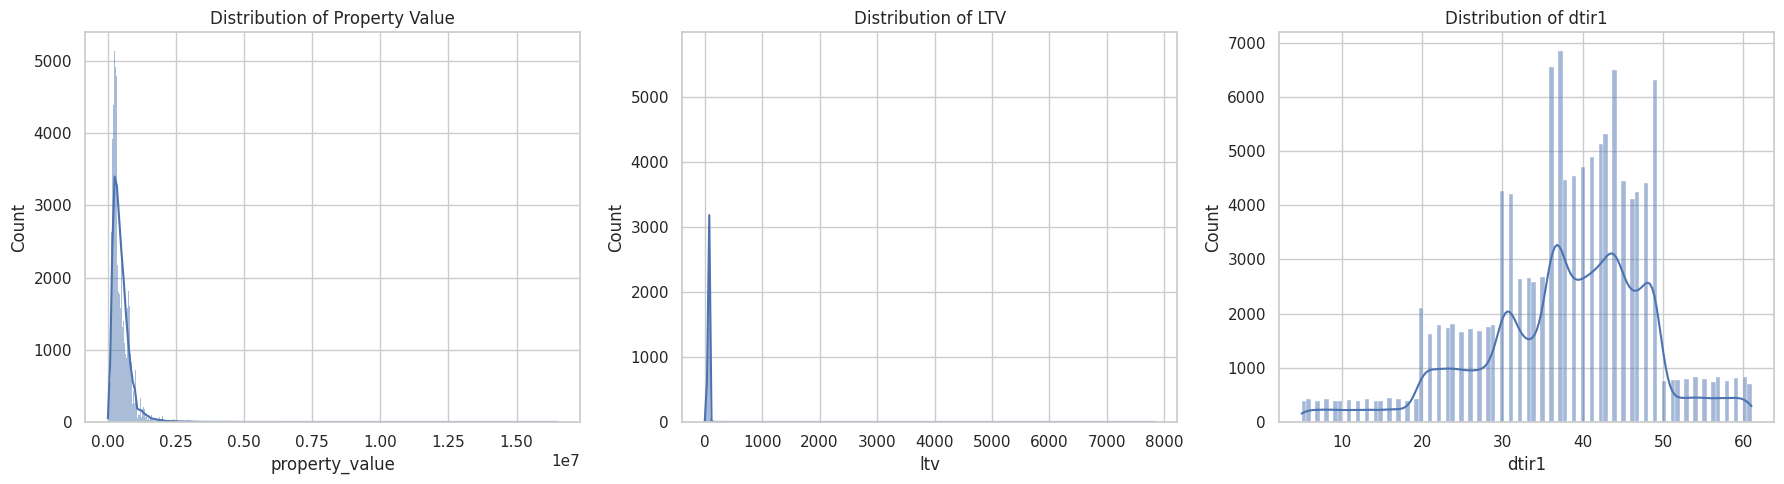

In [27]:
# Set up the matplotlib figure with a specified figure size
plt.figure(figsize=(18, 5))

# Histogram for 'property_value'
plt.subplot(1, 3, 1)  # (rows, columns, panel number)
sns.histplot(df['property_value'].dropna(), kde=True)
plt.title('Distribution of Property Value')

# Histogram for 'LTV'
plt.subplot(1, 3, 2)
sns.histplot(df['ltv'].dropna(), kde=True)
plt.title('Distribution of LTV')

# Histogram for 'dtir1'
plt.subplot(1, 3, 3)
sns.histplot(df['dtir1'].dropna(), kde=True)
plt.title('Distribution of dtir1')


# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


* We will have the similar approach explained for previous histograms. Detailed operations will be performed in the preprocess stage.

In [28]:
from sklearn.impute import SimpleImputer

# Separate columns with different imputation strategies
columns_to_fill_with_mean = ['rate_of_interest', 'interest_rate_spread', 'dtir1']
columns_to_fill_with_median = ['upfront_charges', 'property_value', 'ltv', 'income']

# Impute columns that need mean imputation
mean_imputer = SimpleImputer(strategy='mean')
df[columns_to_fill_with_mean] = mean_imputer.fit_transform(df[columns_to_fill_with_mean])

# Impute columns that need median imputation
median_imputer = SimpleImputer(strategy='median')
df[columns_to_fill_with_median] = median_imputer.fit_transform(df[columns_to_fill_with_median])



In [29]:
(df.isnull().sum()/len(df))*100

loan_limit                   2.249277
approv_in_adv                0.610749
loan_type                    0.000000
loan_purpose                 0.090133
credit_worthiness            0.000000
open_credit                  0.000000
business_or_commercial       0.000000
loan_amount                  0.000000
rate_of_interest             0.000000
interest_rate_spread         0.000000
upfront_charges              0.000000
term                         0.027578
neg_ammortization            0.081388
interest_only                0.000000
lump_sum_payment             0.000000
property_value               0.000000
occupancy_type               0.000000
total_units                  0.000000
income                       0.000000
credit_type                  0.000000
credit_score                 0.000000
co-applicant_credit_type     0.000000
submission_of_application    0.134526
ltv                          0.000000
region                       0.000000
security_type                0.000000
status      

The features with major missing values are imputed. I will perform the imputing method for remaining features (low missing value percentages) in the pipeline design.

In [30]:
## The class for model evaluations

class EvaluationMetrics:
    #model_df =[]
    model_df = pd.DataFrame(columns=['Model', 'Train Accuracy', 'Train Recall', 'Train Precision', 'Train F1-Score',
                                              'Train Log Loss','Test Accuracy', 'Test Recall', 'Test Precision', 'Test F1-Score',
                                              'Test Log Loss', 'Validation Accuracy', 'Validation Recall', 'Validation Precision',
                                              'Validation F1-Score'])

    def __init__(self, pipe, X_train, X_test, y_train, y_test, X_val, y_val):
        self.pipe = pipe
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.X_val = X_val
        self.y_val = y_val

    def print_scores(self):
        # Training set predictions
        y_train_pred = self.pipe.predict(self.X_train)
        y_train_pred_proba = self.pipe.predict_proba(self.X_train)
        train_results_dict = {'accuracy': accuracy_score(self.y_train, y_train_pred),
                              'recall': recall_score(self.y_train, y_train_pred, average='weighted'),
                              'precision': precision_score(self.y_train, y_train_pred, average='weighted'),
                              'f1_score': f1_score(self.y_train, y_train_pred, average='weighted'),
                              'log_loss': log_loss(self.y_train, y_train_pred_proba)}

        # Test set predictions
        y_test_pred = self.pipe.predict(self.X_test)
        y_test_pred_proba = self.pipe.predict_proba(self.X_test)
        test_results_dict = {'accuracy': accuracy_score(self.y_test, y_test_pred),
                             'recall': recall_score(self.y_test, y_test_pred, average='weighted'),
                             'precision': precision_score(self.y_test, y_test_pred, average='weighted'),
                             'f1_score': f1_score(self.y_test, y_test_pred, average='weighted'),
                             'log_loss': log_loss(self.y_test, y_test_pred_proba)}

        # Validation set predictions
        y_val_pred = self.pipe.predict(self.X_val)
        y_val_pred_proba = self.pipe.predict_proba(self.X_val)
        val_results_dict = {'accuracy': accuracy_score(self.y_val, y_val_pred),
                            'recall': recall_score(self.y_val, y_val_pred, average='weighted'),
                            'precision': precision_score(self.y_val, y_val_pred, average='weighted'),
                            'f1_score': f1_score(self.y_val, y_val_pred, average='weighted'),
                            'log_loss': log_loss(self.y_val, y_val_pred_proba)}

        return train_results_dict, test_results_dict, val_results_dict

    def cross_validation(self, cv=5):
        scores = cross_val_score(self.pipe, self.X_train, self.y_train, cv=cv, scoring='accuracy')
        return np.mean(scores), np.std(scores)



    # Plots ROC curve for all classes
    def plot_roc_curve_ovr(self):
        # Calculate FPR and TPR for each class (One-vs-Rest)
        y_test_pred_proba = self.pipe.predict_proba(self.X_test)
        n_classes = y_test_pred_proba.shape[1]
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(self.y_test, y_test_pred_proba[:, i], pos_label=i)

        # Plot ROC curve for each class (One-vs-Rest)
        plt.figure()
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], label=f'Class {i}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve - One-vs-Rest')
        plt.legend(loc="lower right")
        plt.show()

    # Plots confusion matrix
    def plot_confusion_matrix(self, y_train, y_train_pred):
        cm = confusion_matrix(y_train, y_train_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()

    def record_results(self, model_name, train_results, test_results, val_results):
        new_row = {'Model': model_name,
               'Train Accuracy': train_results['accuracy'],
               'Train Recall': train_results['recall'],
               'Train Precision': train_results['precision'],
               'Train F1-Score': train_results['f1_score'],
               'Train Log Loss': train_results['log_loss'],
               'Test Accuracy': test_results['accuracy'],
               'Test Recall': test_results['recall'],
               'Test Precision': test_results['precision'],
               'Test F1-Score': test_results['f1_score'],
               'Test Log Loss': test_results['log_loss'],
               'Validation Accuracy': val_results['accuracy'],
               'Validation Recall': val_results['recall'],
               'Validation Precision': val_results['precision'],
               'Validation F1-Score': val_results['f1_score'],
               'Validation Log Loss': val_results['log_loss']}
        new_row_df= pd.DataFrame(new_row, index=[0])
        self.model_df = pd.concat([self.model_df, new_row_df],ignore_index=True)

## Dummmy Classifier

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, log_loss, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    df.drop('status', axis=1),  # Drop the target variable to create features
    df['status'],               # Target variable
    random_state=0,             # Ensures reproducibility
    test_size=0.4,              # Proportion of dataset to include in initial train split
    stratify=df['status'],      # Ensures train and test sets have similar class distributions
    shuffle=True                # Shuffles the data before splitting
)

# Further split the temporary data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    random_state=0,             # Ensures reproducibility
    test_size=0.5,              # Proportion of dataset to include in validation split
    stratify=y_temp,            # Ensures validation and test sets have similar class distributions
    shuffle=True                # Shuffles the data before splitting
)

# Create a pipeline with a dummy classifier
pipeline_dummy = Pipeline([
    ('dummy_classifier', DummyClassifier(strategy='most_frequent'))  # You can choose different strategies
])

# Train the pipeline (dummy classifier)
pipeline_dummy.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline_dummy.predict(X_test)

# Calculate accuracy as a baseline metric (replace with appropriate evaluation metrics)
accuracy = accuracy_score(y_test, y_pred)


# Now you can use EvaluationMetrics with X_train, X_test, y_train, y_test, X_val, y_val
dummy_metrics = EvaluationMetrics(pipeline_dummy, X_train, X_test, y_train, y_test, X_val, y_val)
train_results, test_results, val_results = dummy_metrics.print_scores()
dummy_metrics.record_results('DummyModel', train_results, test_results, val_results)
dummy_metrics.model_df


,Model,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Train Log Loss,Test Accuracy,Test Recall,Test Precision,Test F1-Score,Test Log Loss,Validation Accuracy,Validation Recall,Validation Precision,Validation F1-Score,Validation Log Loss
0,DummyModel,0.753559,0.753559,0.567852,0.647656,8.882622,0.753548,0.753548,0.567835,0.647641,8.883026,0.753548,0.753548,0.567835,0.647641,8.883026


## Logistic Regression

In [32]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Define categorical and numerical features
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)  # Use categorical_features here
    ])

pipeline_lr = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(random_state=42))
])

# Train the pipeline
pipeline_lr.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline_lr.predict(X_test)


In [33]:
lr_metrics = EvaluationMetrics(pipeline_lr, X_train, X_test, y_train, y_test, X_val, y_val)
train_results, test_results, val_results = lr_metrics.print_scores()
lr_metrics.record_results('Logistic Regression', train_results, test_results, val_results)
lr_metrics.model_df


,Model,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Train Log Loss,Test Accuracy,Test Recall,Test Precision,Test F1-Score,Test Log Loss,Validation Accuracy,Validation Recall,Validation Precision,Validation F1-Score,Validation Log Loss
0,Logistic Regression,0.836607,0.836607,0.838992,0.837701,0.41129,0.834264,0.834264,0.837105,0.835551,0.418293,0.83349,0.83349,0.836147,0.834702,0.413537


## Logistic Regression- Hyperparameter tuning (Grid Search)

In [34]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'classifier__penalty': ['l1', 'l2'],         # Regularization penalty (L1 or L2)
    'classifier__C': [0.001, 0.01, 0.1, 1.0],    # Inverse of regularization strength
    'classifier__solver': ['liblinear', 'saga']  # Solver algorithm
}

# Create a GridSearchCV object
grid_search_lr = GridSearchCV(pipeline_lr, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)# Use all available CPU cores for parallel processing

# Fit the GridSearchCV object to the training data
grid_search_lr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['loan_amount',
                                                                          'rate_of_interest',
                                                                          'interest_rate_spread',
                                                                          'upfront_charges',
                                                                          'term',
                                                                          'property_value',
                                                                          'income',
                                                                          'credit_score',
                                                                          'ltv',
                                                                          'dtir1',
                                                                          'age_ordinal']),
                                                                        ('cat',...
                                                                          'total_units',
                                                                          'credit_type',
                                                                          'co-applicant_credit_type',
                                                                          'submission_of_application',
                                                                          'region',
                                                                          'security_type'])])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('classifier',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.001, 0.01, 0.1, 1.0],
                         'classifier__penalty': ['l1', 'l2'],
                         'classifier__solver': ['liblinear', 'saga']},
             scoring='roc_auc')

Best Hyperparameters:
{'classifier__C': 1.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Score (Accuracy): 0.8553620540836773


In [35]:
from sklearn.pipeline import Pipeline

# Define a pipeline with preprocessing and the logistic regression model
best_lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Your preprocessing steps
    ('classifier', LogisticRegression(C=0.01, max_iter=100, penalty='l1', solver='liblinear'))  # Best parameters
])

# Fit the pipeline to the training data
best_lr_pipeline.fit(X_train, y_train)

# Make predictions using the pipeline
y_pred = best_lr_pipeline.predict(X_test)



In [36]:
best_lr_metrics = EvaluationMetrics(best_lr_pipeline, X_train, X_test, y_train, y_test, X_val, y_val)
train_results, test_results, val_results = best_lr_metrics.print_scores()
best_lr_metrics.record_results('Logistic Regression Grid Search', train_results, test_results, val_results)
best_lr_metrics.model_df


,Model,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Train Log Loss,Test Accuracy,Test Recall,Test Precision,Test F1-Score,Test Log Loss,Validation Accuracy,Validation Recall,Validation Precision,Validation F1-Score,Validation Log Loss
0,Logistic Regression Grid Search,0.866404,0.866404,0.879314,0.84917,0.34286,0.864734,0.864734,0.877,0.84726,0.348212,0.865608,0.865608,0.878293,0.848234,0.345005


### Logistic Regression - Cross validation

In [37]:
# Create an instance of the EvaluationMetrics class
cross_lr_metrics = EvaluationMetrics(best_lr_pipeline, X_train, X_test, y_train, y_test, X_val, y_val)

# Perform cross-validation
mean_cv_score, std_cv_score = cross_lr_metrics.cross_validation(cv=2)

# Display the mean and standard deviation of cross-validation scores
print(f"Mean Cross-Validation Score: {mean_cv_score:.4f}")
print(f"Standard Deviation of Cross-Validation Scores: {std_cv_score:.4f}")


Mean Cross-Validation Score: 0.8640
Standard Deviation of Cross-Validation Scores: 0.0014


**Interpretation:** A mean Cross-Validation Score of 0.8657 with a low Standard Deviation indicates that the logistic regression model is performing well on the training data and is relatively stable in its performance across different subsets of the data.  

### Support Vector Machine (SVM)

In [38]:
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV

# Create an SVM classifier with probability estimates enabled
svm_classifier = SVC(probability=True, random_state=42)

# Wrap the classifier in a CalibratedClassifierCV to enable probability estimates
calibrated_classifier = CalibratedClassifierCV(svm_classifier, method='sigmoid')

# Create an SVM pipeline with the calibrated classifier
svm_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),  # Reuse the preprocessing steps
    ('smote', SMOTE(random_state=42)),  # Reuse SMOTE
    ('classifier', calibrated_classifier)  # Use the calibrated SVM classifier
])

# Train the SVM pipeline
svm_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['loan_amount',
                                                   'rate_of_interest',
                                                   'interest_rate_spread',
                                                   'upfront_charges', 'term',
                                                   'property_value', 'income',
                                                   'credit_score', 'ltv',
                                                   'dtir1', 'age_ordinal']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   S...
                                                   'credit_worthiness',
                                                   'open_credit',
                                                   'business_or_commercial',
                                                   'neg_ammortization',
                                                   'interest_only',
                                                   'lump_sum_payment',
                                                   'occupancy_type',
                                                   'total_units', 'credit_type',
                                                   'co-applicant_credit_type',
                                                   'submission_of_application',
                                                   'region',
                                                   'security_type'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 CalibratedClassifierCV(estimator=SVC(probability=True,
                                                      random_state=42)))])

In [39]:
svm_metrics = EvaluationMetrics(svm_pipeline, X_train, X_test, y_train, y_test, X_val, y_val)
train_results, test_results, val_results = svm_metrics.print_scores()
svm_metrics.record_results('SVM', train_results, test_results, val_results)

In [40]:
svm_metrics.model_df

,Model,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Train Log Loss,Test Accuracy,Test Recall,Test Precision,Test F1-Score,Test Log Loss,Validation Accuracy,Validation Recall,Validation Precision,Validation F1-Score,Validation Log Loss
0,SVM,0.965214,0.965214,0.969352,0.965933,0.098067,0.964519,0.964519,0.968683,0.965253,0.099818,0.962804,0.962804,0.967328,0.963603,0.102249


### SVM- Cross Validation

In [41]:
cross_svm_metrics = EvaluationMetrics(svm_pipeline, X_train, X_test, y_train, y_test, X_val, y_val)

# Perform cross-validation
mean_cv_score, std_cv_score = cross_svm_metrics.cross_validation(cv=2)

# Display the mean and standard deviation of cross-validation scores
print(f"Mean Cross-Validation Score: {mean_cv_score:.4f}")
print(f"Standard Deviation of Cross-Validation Scores: {std_cv_score:.4f}")


Mean Cross-Validation Score: 0.9635
Standard Deviation of Cross-Validation Scores: 0.0001


## XGBoost

In [52]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Create a LabelEncoder
label_encoder = LabelEncoder()

# Encode the target variable
y_train_encoded = label_encoder.fit_transform(y_train)

# Define the XGBoost classifier
xgb_classifier = XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create an XGBoost pipeline
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_classifier)
])

# Train the XGBoost pipeline on the training data with encoded target variable
xgb_pipeline.fit(X_train, y_train_encoded)

# Make predictions on the test set
y_pred = xgb_pipeline.predict(X_test)

# Decode the predicted labels to get the original class labels
y_pred_original = label_encoder.inverse_transform(y_pred)

# Convert y_true and y_val to integers for evaluation
y_true_encoded = label_encoder.transform(y_test)
y_val_encoded = label_encoder.transform(y_val)

# Now, create an instance of EvaluationMetrics with the XGBoost pipeline
xgb_metrics = EvaluationMetrics(xgb_pipeline, X_train, X_test, y_train_encoded, y_pred_original, X_val, y_val_encoded)

# Calculate and record the evaluation metrics
train_results, test_results, val_results = xgb_metrics.print_scores()
xgb_metrics.record_results('XGBOOST', train_results, test_results, val_results)

# Access the model_df attribute to get the results
xgb_metrics.model_df

TypeError: ignored

In [50]:
# Now, create an instance of EvaluationMetrics with the XGBoost pipeline
xgb_metrics = EvaluationMetrics(xgb_pipeline, X_train, X_test, y_train_encoded, y_pred_original, X_val, y_val)

# Calculate and record the evaluation metrics
train_results, test_results, val_results = xgb_metrics.print_scores()
xgb_metrics.record_results('XGBOOST', train_results, test_results, val_results)

# Access the model_df attribute to get the results
xgb_metrics.model_df

TypeError: ignored